## Model Object

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchvision.ops import nms
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import random
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

## Methods

In [4]:
'''
Reference: https://github.com/eriklindernoren/PyTorch-YOLOv3/tree/47b7c912877ca69db35b8af3a38d6522681b3bb3
'''

def xywh2xyxy(x):
    # from [x, y, w, h] to [x1, y1, x2, y2]
    y = x.new(x.shape)
    y[:, 0] = x[:, 0] - x[:, 2] / 2
    y[:, 1] = x[:, 1] - x[:, 3] / 2
    y[:, 2] = x[:, 0] + x[:, 2] / 2
    y[:, 3] = x[:, 1] + x[:, 3] / 2
    return y

def bboxes_from_anchors(anchors, confidence_threshold, iou_threshold, labels_dict):
    nbatches = anchors.shape[0]
    batch_bboxes = []
    labels = []

    for nbatch in range(nbatches):
        img_anchor = anchors[nbatch]
        confidence_filter = img_anchor[:, 4] > confidence_threshold
        img_anchor = img_anchor[confidence_filter]
        keep = nms(xywh2xyxy(img_anchor[:, :4]), img_anchor[:, 4], iou_threshold)
            
        img_bboxes = img_anchor[keep]
        batch_bboxes.append(img_bboxes)
        if len(img_bboxes) == 0:
            labels.append([])
            continue
        labels.append([labels_dict[x.item()] for x in img_bboxes[:, 5:].argmax(1)])

    return batch_bboxes, labels

def draw_save_image(bboxes,path,img_size):
  # Bounding-box colors
  cmap = plt.get_cmap("tab20b")
  colors = [cmap(i) for i in np.linspace(0, 1, 20)]

  # path = 'plane1.jpg'
  img_pil = Image.open(path).resize((img_size,img_size))
  width, height = img_pil.size  
  img1 = np.array(img_pil)
  my_dpi = 90
  plt.figure(figsize=(320/my_dpi, 320/my_dpi), dpi=my_dpi)
  fig, ax = plt.subplots(1)
  ax.imshow(img1)
  classes={
      0:'Airplane',
      1:'Bird'
  }

  for detections in bboxes:
    detections = detections.cpu()
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_conf, cls_pred_tensor in detections:
      cls_pred = round(cls_pred_tensor.item())
      if (cls_pred == 1):
        cls_conf = 1 - cls_conf
      # print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf))

      box_w = x2 - x1
      box_h = y2 - y1
      x1 = x1- x2/2
      y1 = y1 - y2/2
      # color = bbox_colors[int(np.where(unique_labels == cls_pred.item())[0])]
      color = bbox_colors[int(np.where(unique_labels == cls_pred_tensor.item())[0])]


      # Create a Rectangle patch
      bbox = patches.Rectangle((x1, y1), x2, y2, linewidth=2, edgecolor=color, facecolor="none")
      # Add the bbox to the plot
      ax.add_patch(bbox)
      # Add label
      plt.text(
          x1,
          y1,
          s=classes[int(cls_pred)]+str("  %.2f" % (cls_conf)),
          color="white",
          verticalalignment="top",
          bbox={"color": color, "pad": 0},
      )

  # Save generated image with detections
  plt.axis("off")
  plt.gca().xaxis.set_major_locator(NullLocator())
  plt.gca().yaxis.set_major_locator(NullLocator())
  filename = path.split("/")[-1].split(".")[0]
  plt.savefig(f"{filename}.png", bbox_inches="tight", pad_inches=0.0)
  plt.show()
  plt.close()

def inference_image(img_path, device, model, confidence_threshold, iou_threshold, labels_dict, test_transform):
  image = Image.open(img_path)
  tensor_image = test_transform(image)
  tensor_image = tensor_image.unsqueeze(0)
  target = torch.rand(1,6)  # random_target
  output_anchors, loss = model(tensor_image.to(device),target.to(device))


  bboxes, labels = bboxes_from_anchors(output_anchors, confidence_threshold, iou_threshold, labels_dict)
  draw_save_image(bboxes,img_path,img_size=320)

## Hyperparameter & Load Model

In [5]:
device='cuda'

labels_dict={
    0:'Airplane',
    1:'Bird'
}
test_transform = transforms.Compose([
                                    transforms.Resize(size=(320,320)),
                                    transforms.ToTensor()
])
model = torch.jit.load('/content/drive/My Drive/Colab Notebooks/YOLOv4/jit_model_det120.pt')
model.to(device)
model.eval()
a = 1

## Inference

In [12]:
import glob2
filelist = glob2.glob('./*jpg*')
len(filelist)

20

<Figure size 320x320 with 0 Axes>

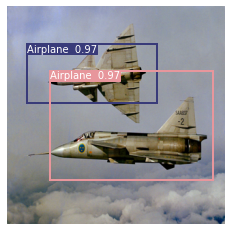

<Figure size 320x320 with 0 Axes>

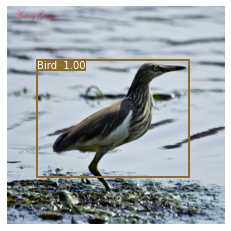

<Figure size 320x320 with 0 Axes>

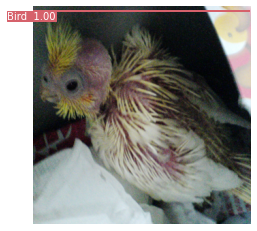

<Figure size 320x320 with 0 Axes>

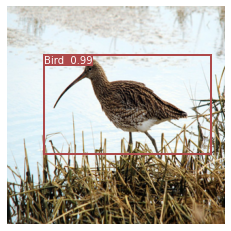

<Figure size 320x320 with 0 Axes>

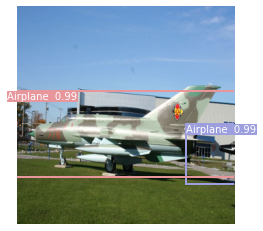

<Figure size 320x320 with 0 Axes>

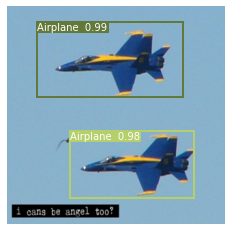

<Figure size 320x320 with 0 Axes>

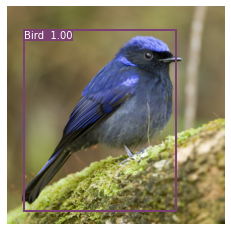

<Figure size 320x320 with 0 Axes>

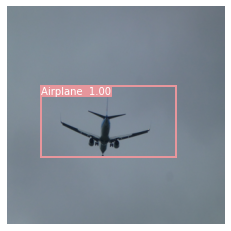

<Figure size 320x320 with 0 Axes>

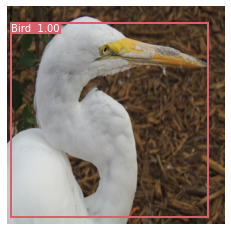

<Figure size 320x320 with 0 Axes>

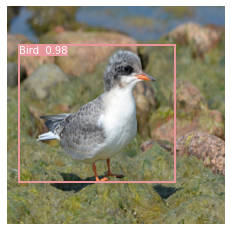

<Figure size 320x320 with 0 Axes>

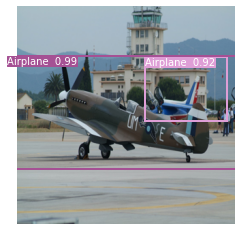

<Figure size 320x320 with 0 Axes>

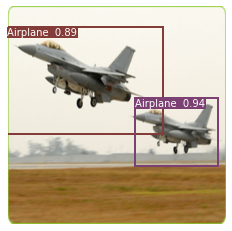

<Figure size 320x320 with 0 Axes>

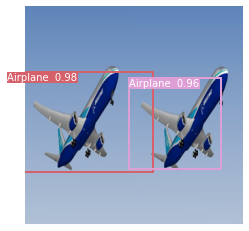

<Figure size 320x320 with 0 Axes>

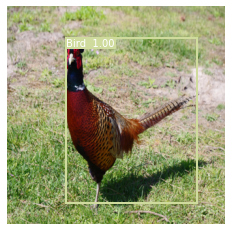

<Figure size 320x320 with 0 Axes>

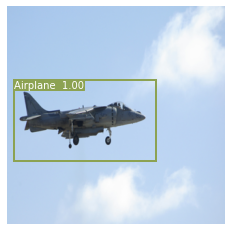

<Figure size 320x320 with 0 Axes>

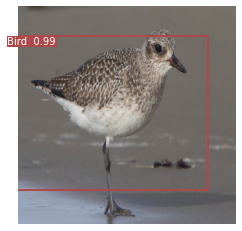

<Figure size 320x320 with 0 Axes>

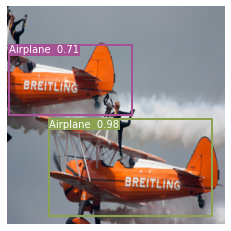

<Figure size 320x320 with 0 Axes>

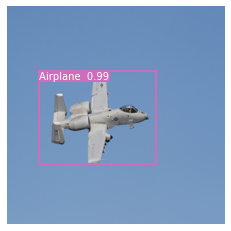

<Figure size 320x320 with 0 Axes>

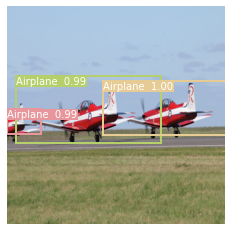

<Figure size 320x320 with 0 Axes>

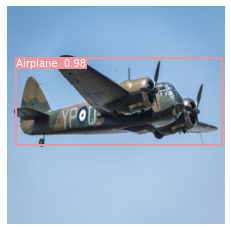

In [13]:
confidence_threshold = 0.7
iou_threshold = 0.25
for img_path in filelist:
  inference_image(img_path, device, model, confidence_threshold, iou_threshold, labels_dict, test_transform)

In [8]:
# !cp *png '/content/drive/My Drive/Colab Notebooks/YOLOv4/png_output/'   #save image with bounding box